### Učitavanje potrebnih biblioteka

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import roc_curve
from itertools import combinations
import timm
import os
import shutil
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm


### Postavljanje seta podataka (Dataset)

In [2]:
class FaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

Koristi se baza slika lica "Labelled Faces in the Wild (LFW) Dataset"
https://www.kaggle.com/datasets/jessicali9530/lfw-dataset

In [3]:
DATA_DIR = '../data/people/'

In [73]:
dataset = FaceDataset(
    data_dir = DATA_DIR
)

In [74]:
print("Veličina seta podataka:", len(dataset))

Veličina seta podataka: 1800


1


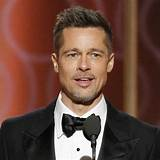

In [81]:
image, label = dataset[151]
print(label)
image

In [82]:
target_to_class = {v: k for k, v in ImageFolder(DATA_DIR).class_to_idx.items()}
print(target_to_class)

{0: 'Angelina Jolie', 1: 'Brad Pitt', 2: 'Denzel Washington', 3: 'Hugh Jackman', 4: 'Jennifer Lawrence', 5: 'Johnny Depp', 6: 'Kate Winslet', 7: 'Leonardo DiCaprio', 8: 'Megan Fox', 9: 'Natalie Portman', 10: 'Nicole Kidman', 11: 'Robert Downey Jr', 12: 'Sandra Bullock', 13: 'Scarlett Johansson', 14: 'Tom Cruise', 15: 'Tom Hanks', 16: 'Will Smith'}


In [23]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = FaceDataset(DATA_DIR, transform)

In [24]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

### Učitavanje podataka (Dataloaders)

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### PyTorch model

In [83]:
class FaceClassifer(nn.Module):
    def __init__(self, num_classes):
        super(FaceClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [27]:
model = FaceClassifer(num_classes=len(dataset))
print(str(model)[:500])

FaceClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  


## Treniranje modela

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Postavljanje setova podataka (datasets)

In [84]:
import os
import shutil
import random

main_data_folder = '../data/people/'
train_folder = '../data/train/'
valid_folder = '../data/valid/'
test_folder = '../data/test/'

# Remove existing train, valid, and test folders (if they exist)
for folder in [train_folder, valid_folder, test_folder]:
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Delete the folder and its contents

# Create destination folders
for folder in [train_folder, valid_folder, test_folder]:
    os.makedirs(folder, exist_ok=True)

for class_name in os.listdir(main_data_folder):
    class_path = os.path.join(main_data_folder, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip non-folder items

    # List all images in the class folder
    images = os.listdir(class_path)
    random.shuffle(images)  # Shuffle images for randomness

    total_images = len(images)
    
    # Skip classes with fewer than 3 images
    if total_images < 3:
        print(f"Skipping class {class_name}: only {total_images} image(s).")
        continue

    # Create class subfolders in train, valid, and test directories
    os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

    # Ensure at least 1 image in test and 1 in validation
    test_images = images[:15]  # First image for testing
    valid_images = images[15:30]  # Second image for validation
    train_images = images[30:]  # Remaining images for training

    # Move images to respective folders
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_folder, class_name, img))
    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_folder, class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_folder, class_name, img))

    print(f"Class {class_name}: {len(train_images)} train, {len(valid_images)} valid, {len(test_images)} test images.")

Class Angelina Jolie: 70 train, 15 valid, 15 test images.
Class Brad Pitt: 70 train, 15 valid, 15 test images.
Class Denzel Washington: 70 train, 15 valid, 15 test images.
Class Hugh Jackman: 70 train, 15 valid, 15 test images.
Class Jennifer Lawrence: 70 train, 15 valid, 15 test images.
Class Johnny Depp: 70 train, 15 valid, 15 test images.
Class Kate Winslet: 70 train, 15 valid, 15 test images.
Class Leonardo DiCaprio: 70 train, 15 valid, 15 test images.
Class Megan Fox: 70 train, 15 valid, 15 test images.
Class Natalie Portman: 70 train, 15 valid, 15 test images.
Class Nicole Kidman: 70 train, 15 valid, 15 test images.
Class Robert Downey Jr: 70 train, 15 valid, 15 test images.
Class Sandra Bullock: 70 train, 15 valid, 15 test images.
Class Scarlett Johansson: 170 train, 15 valid, 15 test images.
Class Tom Cruise: 70 train, 15 valid, 15 test images.
Class Tom Hanks: 70 train, 15 valid, 15 test images.
Class Will Smith: 70 train, 15 valid, 15 test images.


In [85]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../data/train/'
valid_folder = '../data/valid/'
test_folder = '../data/test/'

train_dataset = FaceDataset(train_folder, transform=transform)
val_dataset = FaceDataset(valid_folder, transform=transform)
test_dataset = FaceDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [32]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = FaceClassifer(num_classes=len(dataset))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

cpu


Training loop:   0%|          | 0/182 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 5.595284966252574, Validation loss: 7.2226798283008575


Training loop:   0%|          | 0/182 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 2.605556639205333, Validation loss: 6.127743439986624


Training loop:   0%|          | 0/182 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 1.2035172740645774, Validation loss: 4.948137219023625


Training loop:   0%|          | 0/182 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.4439971978955233, Validation loss: 4.422225621908274


Training loop:   0%|          | 0/182 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.10290039536625989, Validation loss: 4.370586284125156


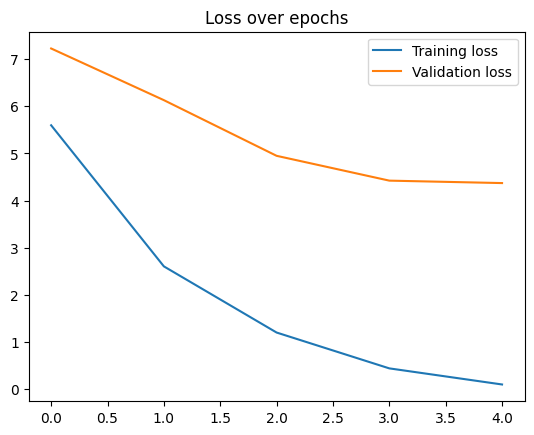

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [69]:
import os
import random
from tqdm import tqdm

def generate_pairs(test_folder, valid_folder, max_pairs=5000):
    positive_pairs = []
    negative_pairs = []
    
    # Combine test and validation folders
    all_folders = [test_folder, valid_folder]
    
    # Get the classes from the test and validation folders
    class_folders = {}
    for folder in all_folders:
        class_folders[folder] = os.listdir(folder)
    
    # Create a dictionary to combine test and validation images for each class
    combined_classes = {}
    for folder in all_folders:
        for class_name in class_folders[folder]:
            class_path = os.path.join(folder, class_name)
            images = os.listdir(class_path)
            
            if class_name not in combined_classes:
                combined_classes[class_name] = []
            combined_classes[class_name].extend([os.path.join(class_path, img) for img in images])
    
    # Now we have the combined images for each class, let's generate pairs
    for _ in tqdm(range(max_pairs), desc="Generating pairs"):
        # Randomly choose a class that has images from both test and validation
        class_name = random.choice(list(combined_classes.keys()))
        images = combined_classes[class_name]

        # Create positive pair (same class, one image from test, one from validation)
        if len(images) > 1:
            img1, img2 = random.sample(images, 2)  # Randomly select 2 images for a positive pair
            positive_pairs.append((img1, img2))
        
        # Create negative pair (different classes)
        other_class_name = random.choice([name for name in combined_classes if name != class_name])
        other_class_images = combined_classes[other_class_name]
        
        if len(other_class_images) > 0:
            img1 = random.choice(images)  # Randomly select one image from the current class
            img2 = random.choice(other_class_images)  # Randomly select one image from the other class
            negative_pairs.append((img1, img2))
    
    print(f"Generated {len(positive_pairs)} positive pairs and {len(negative_pairs)} negative pairs.")
    return positive_pairs, negative_pairs

positive_pairs, negative_pairs = generate_pairs(test_folder, valid_folder, max_pairs=10000)

Generating pairs: 100%|██████████| 10000/10000 [00:00<00:00, 26607.78it/s]

Generated 10000 positive pairs and 10000 negative pairs.


In [64]:
def test_model(model, positive_pairs, negative_pairs, transform, threshold=0.5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_labels = []
    all_scores = []

    def load_image(image_path):
        from PIL import Image
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        for pair, label in [(positive_pairs, 1), (negative_pairs, 0)]:
            for img1_path, img2_path in tqdm(pair, desc=f"Testing {'Positive' if label == 1 else 'Negative'} Pairs"):
                img1 = load_image(img1_path)
                img2 = load_image(img2_path)

                # Compute embeddings
                embedding1 = model(img1)
                embedding2 = model(img2)

                # Calculate distance
                distance = F.pairwise_distance(embedding1, embedding2).item()
                score = 1 - distance  # Higher score for closer embeddings

                all_scores.append(score)
                all_labels.append(label)

    # Calculate FAR, FRR, and EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    fnr = 1 - tpr

    # Calculate EER
    eer_threshold = thresholds[(np.abs(fpr - fnr)).argmin()]
    eer = fpr[(np.abs(fpr - fnr)).argmin()]
    return fpr, fnr, eer, eer_threshold

Testing Negative Pairs: 100%|██████████| 10000/10000 [07:30<00:00, 22.19it/s]


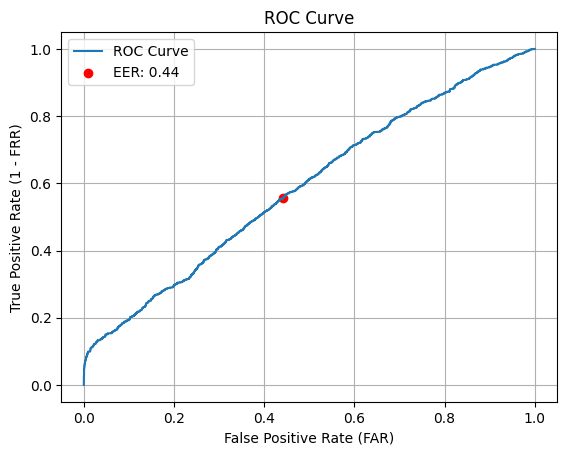

Equal Error Rate (EER): 0.4425
Threshold at EER: -440.0154724121094


In [70]:
# Test the model
fpr, fnr, eer, eer_threshold = test_model(model, positive_pairs, negative_pairs, transform)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, 1 - fnr, label="ROC Curve")
plt.scatter([eer], [1 - eer], color='red', label=f"EER: {eer:.2f}")
plt.xlabel("False Positive Rate (FAR)")
plt.ylabel("True Positive Rate (1 - FRR)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print(f"Equal Error Rate (EER): {eer}")
print(f"Threshold at EER: {eer_threshold}")